In [1]:
%matplotlib inline

In [2]:
from theano.sandbox import cuda
import utils; reload(utils)
from utils import *
from __future__ import division, print_function

Using Theano backend.


In [3]:
path = 'data/movielens/ml-latest-small/'

# Set Up Data

Here are the categories for each row of data:

In [4]:
ratings = pd.read_csv(path+'ratings.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [5]:
len(ratings)

100004

In [6]:
movie_names = pd.read_csv(path + 'movies.csv').set_index('movieId')['title'].to_dict()

In [7]:
movie_names[3]

'Grumpier Old Men (1995)'

In [8]:
users = ratings.userId.unique()
movies = ratings.movieId.unique()

This index relation is very helpuful for when we set up our embeddings.

In [9]:
userid2idx = {o:i for i,o in enumerate(users)}
movieid2idx = {o:i for i,o in enumerate(movies)}

In [10]:
ratings.movieId = ratings.movieId.apply(lambda x: movieid2idx[x])
ratings.userId = ratings.userId.apply(lambda x: userid2idx[x])

This sets our boundaries on the number of users and movies in the dataset.

In [11]:
user_min, user_max, movie_min, movie_max = (ratings.userId.min(), ratings.userId.max(), 
                                            ratings.movieId.min(), ratings.movieId.max())
user_min, user_max, movie_min, movie_max

(0, 670, 0, 9065)

In [12]:
n_users = ratings.userId.nunique()
n_movies = ratings.movieId.nunique()
n_users, n_movies

(671, 9066)

In [13]:
n_factors = 50

In [14]:
np.random.seed = 42

This randomly splits up the data between the training and validation sets.

In [15]:
msk = np.random.rand(len(ratings)) < .8
trn = ratings[msk]
val = ratings[~msk]

# Simple Embedding Layer through Dot Product

We're going to start off with a model consisting of an input of the user and movie embeddings, and an architecture performing the dot product between both the user and movie embeddings.

In [16]:
user_in = Input(shape = (1,), dtype = 'int64', name = 'user_in')
u = Embedding(n_users, n_factors, input_length = 1, W_regularizer = l2(1e-4))(user_in)
movie_in = Input(shape = (1,), dtype = 'int64', name = 'movie_in')
m = Embedding(n_movies, n_factors, input_length = 1, W_regularizer = l2(1e-4))(movie_in)

In [17]:
x = merge([u, m], mode = 'dot')
x = Flatten()(x)
model = Model([user_in, movie_in], x)
model.compile(Adam(.001), loss = 'mse')

In [18]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size = 64, nb_epoch = 3, 
          validation_data = ([val.userId, val.movieId], val.rating))

Train on 80021 samples, validate on 19983 samples
Epoch 1/3
80021/80021 [==============================] - 13s - loss: 9.9557 - val_loss: 3.8605
Epoch 2/3
80021/80021 [==============================] - 17s - loss: 3.1497 - val_loss: 2.0196
Epoch 3/3
80021/80021 [==============================] - 17s - loss: 2.4161 - val_loss: 1.6486


In [19]:
model.optimizer.lr = .01

In [20]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size = 64, nb_epoch = 3, 
          validation_data = ([val.userId, val.movieId], val.rating))

Train on 80021 samples, validate on 19983 samples
Epoch 1/3
80021/80021 [==============================] - 17s - loss: 2.2437 - val_loss: 1.5275
Epoch 2/3
80021/80021 [==============================] - 17s - loss: 2.1776 - val_loss: 1.4713
Epoch 3/3
80021/80021 [==============================] - 17s - loss: 2.1411 - val_loss: 1.4542


This model seemed to work okay, but it can definitely use some more input values to reduce the loss function.

# Embedding Layer with Bias Factor

Now we'll try the same model as our last attempt, except this time we'll input an extra bias term, to account as a representation for how positive/negative the user is towards certain movies, and also for how good each movie is.

In [21]:
def embedding_input(name, n_in, n_out, reg):
    inp = Input(shape = (1,), dtype = 'int64', name = name)
    return inp, Embedding(n_in, n_out, input_length = 1, W_regularizer = l2(reg))(inp)

In [22]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [23]:
def create_bias(inp, n_in):
    x = Embedding(n_in, 1, input_length = 1)(inp)
    return Flatten()(x)

In [24]:
ub = create_bias(user_in, n_users)
mb = create_bias(movie_in, n_movies)

In [25]:
x = merge([u, m], mode = 'dot')
x = Flatten()(x)
x = merge([x, ub], mode = 'sum')
x = merge([x, mb], mode = 'sum')
model = Model([user_in, movie_in], x)
model.compile(Adam(.001), loss = 'mse')

In [26]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size = 64, nb_epoch = 3, 
          validation_data = ([val.userId, val.movieId], val.rating))

Train on 80021 samples, validate on 19983 samples
Epoch 1/3
80021/80021 [==============================] - 14s - loss: 8.8275 - val_loss: 3.1169
Epoch 2/3
80021/80021 [==============================] - 18s - loss: 2.5840 - val_loss: 1.6268
Epoch 3/3
80021/80021 [==============================] - 18s - loss: 1.9987 - val_loss: 1.3330


In [27]:
model.optimizer.lr = .01

In [28]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size = 64, nb_epoch = 5, 
          validation_data = ([val.userId, val.movieId], val.rating))

Train on 80021 samples, validate on 19983 samples
Epoch 1/5
80021/80021 [==============================] - 18s - loss: 1.8405 - val_loss: 1.2251
Epoch 2/5
80021/80021 [==============================] - 18s - loss: 1.7459 - val_loss: 1.1600
Epoch 3/5
80021/80021 [==============================] - 18s - loss: 1.6657 - val_loss: 1.1271
Epoch 4/5
80021/80021 [==============================] - 18s - loss: 1.5918 - val_loss: 1.1026
Epoch 5/5
80021/80021 [==============================] - 18s - loss: 1.5188 - val_loss: 1.0735


In [29]:
model.optimizer.lr = .001

In [30]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size = 64, nb_epoch = 8, 
          validation_data = ([val.userId, val.movieId], val.rating))

Train on 80021 samples, validate on 19983 samples
Epoch 1/8
80021/80021 [==============================] - 18s - loss: 1.4478 - val_loss: 1.0410
Epoch 2/8
80021/80021 [==============================] - 18s - loss: 1.3782 - val_loss: 1.0201
Epoch 3/8
80021/80021 [==============================] - 18s - loss: 1.3108 - val_loss: 0.9967
Epoch 4/8
80021/80021 [==============================] - 18s - loss: 1.2460 - val_loss: 0.9718
Epoch 5/8
80021/80021 [==============================] - 18s - loss: 1.1854 - val_loss: 0.9525
Epoch 6/8
80021/80021 [==============================] - 18s - loss: 1.1270 - val_loss: 0.9331
Epoch 7/8
80021/80021 [==============================] - 18s - loss: 1.0724 - val_loss: 0.9150
Epoch 8/8
80021/80021 [==============================] - 18s - loss: 1.0202 - val_loss: 0.8981


In [31]:
model.optimizer.lr = .0001

In [32]:
model.fit([trn.userId, trn.movieId], trn.rating, batch_size = 64, nb_epoch = 6, 
          validation_data = ([val.userId, val.movieId], val.rating))

Train on 80021 samples, validate on 19983 samples
Epoch 1/6
80021/80021 [==============================] - 18s - loss: 0.9709 - val_loss: 0.8828
Epoch 2/6
80021/80021 [==============================] - 18s - loss: 0.9243 - val_loss: 0.8682
Epoch 3/6
80021/80021 [==============================] - 18s - loss: 0.8808 - val_loss: 0.8564
Epoch 4/6
80021/80021 [==============================] - 19s - loss: 0.8399 - val_loss: 0.8472
Epoch 5/6
80021/80021 [==============================] - 19s - loss: 0.8026 - val_loss: 0.8372
Epoch 6/6
80021/80021 [==============================] - 19s - loss: 0.7683 - val_loss: 0.8275


This works significantly better than our first model!

# Result Analysis

Since there's so many movies, lets analyze the top 1000 most popular movies.

In [34]:
g = ratings.groupby("movieId")['rating'].count()
topMovies = g.sort_values(ascending = False)[:1000]
topMovies = np.array(topMovies.index)

Here, we make a small model that simply takes a movie ID input and produces a bias term output, that depicts how popular the movie is.

In [37]:
get_movie_bias_term = Model(movie_in, mb)
movie_bias_value = get_movie_bias_term.predict(topMovies)
movie_ratings = [(b[0], movie_names[movies[i]]) for i,b in zip(topMovies, movie_bias_value)]

In [38]:
sorted(movie_ratings, key = itemgetter(0))[:5]

[(0.044780109, 'Batman & Robin (1997)'),
 (0.090702392, 'Blair Witch Project, The (1999)'),
 (0.13713357, 'Lost in Space (1998)'),
 (0.13919899, 'Dick Tracy (1990)'),
 (0.14351796, 'Wild Wild West (1999)')]

In [39]:
sorted(movie_ratings, key = itemgetter(0), reverse = True)[:5]

[(1.3920501, "Howl's Moving Castle (Hauru no ugoku shiro) (2004)"),
 (1.369902, 'My Neighbor Totoro (Tonari no Totoro) (1988)'),
 (1.3454639, 'Shawshank Redemption, The (1994)'),
 (1.329205, 'Moon (2009)'),
 (1.2750252, 'Three Colors: Blue (Trois couleurs: Bleu) (1993)')]

PCA from 50 components to 3 components.

In [40]:
get_movie_emb = Model(movie_in, m)
movie_emb = np.squeeze(get_movie_emb.predict([topMovies]))
movie_emb.shape

(1000, 50)

In [41]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 3)
movie_pca = pca.fit(movie_emb.T).components_

Component 1

In [43]:
comp0 = movie_pca[0]
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(comp0, topMovies)]

In [44]:
sorted(movie_comp, key = itemgetter(0))[:5]

[(-0.015893474, 'Anaconda (1997)'),
 (-0.0054417094, 'Godzilla (1998)'),
 (-0.0036372328, 'Showgirls (1995)'),
 (-0.0031671631, 'Daredevil (2003)'),
 (-0.002420763, 'Mission to Mars (2000)')]

In [45]:
sorted(movie_comp, key = itemgetter(0), reverse = True)[:5]

[(0.059872773, 'Star Wars: Episode IV - A New Hope (1977)'),
 (0.059303764, 'Monty Python and the Holy Grail (1975)'),
 (0.0578353, 'Lord of the Rings: The Return of the King, The (2003)'),
 (0.057779439, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (0.056668226, 'Pulp Fiction (1994)')]

Component 2

In [46]:
comp1 = movie_pca[1]
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(comp1, topMovies)]

In [47]:
sorted(movie_comp, key = itemgetter(0))[:5]

[(-0.12721691, 'Independence Day (a.k.a. ID4) (1996)'),
 (-0.11518613, 'Armageddon (1998)'),
 (-0.093614295, 'Titanic (1997)'),
 (-0.088117987, 'Stargate (1994)'),
 (-0.087609731, 'Jurassic Park (1993)')]

In [48]:
sorted(movie_comp, key = itemgetter(0), reverse = True)[:5]

[(0.074462511, 'Apocalypse Now (1979)'),
 (0.073159225, 'Vertigo (1958)'),
 (0.071586706, 'Annie Hall (1977)'),
 (0.070397601, 'Harold and Maude (1971)'),
 (0.068788886, 'No Country for Old Men (2007)')]

Component 3

In [49]:
comp2 = movie_pca[2]
movie_comp = [(f, movie_names[movies[i]]) for f,i in zip(comp2, topMovies)]

In [50]:
sorted(movie_comp, key = itemgetter(0))[:5]

[(-0.096356556, "Romy and Michele's High School Reunion (1997)"),
 (-0.087282598, 'Sound of Music, The (1965)'),
 (-0.086739644, 'Postman, The (Postino, Il) (1994)'),
 (-0.085636057, 'Babe (1995)'),
 (-0.083581761, 'While You Were Sleeping (1995)')]

In [51]:
sorted(movie_comp, key = itemgetter(0), reverse = True)[:5]

[(0.10901203, 'Lord of the Rings: The Two Towers, The (2002)'),
 (0.10656285, 'Mad Max: Fury Road (2015)'),
 (0.10347898, 'Lord of the Rings: The Fellowship of the Ring, The (2001)'),
 (0.097211495, 'Matrix, The (1999)'),
 (0.095523052, 'Kill Bill: Vol. 1 (2003)')]

Here's a graphical representation of Component 1 and 2.

In [52]:
import sys
stdout, stderr = sys.stdout, sys.stderr
reload(sys)
sys.setdefaultencoding('utf-8')
sys.stdout, sys.stderr = stdout, stderr

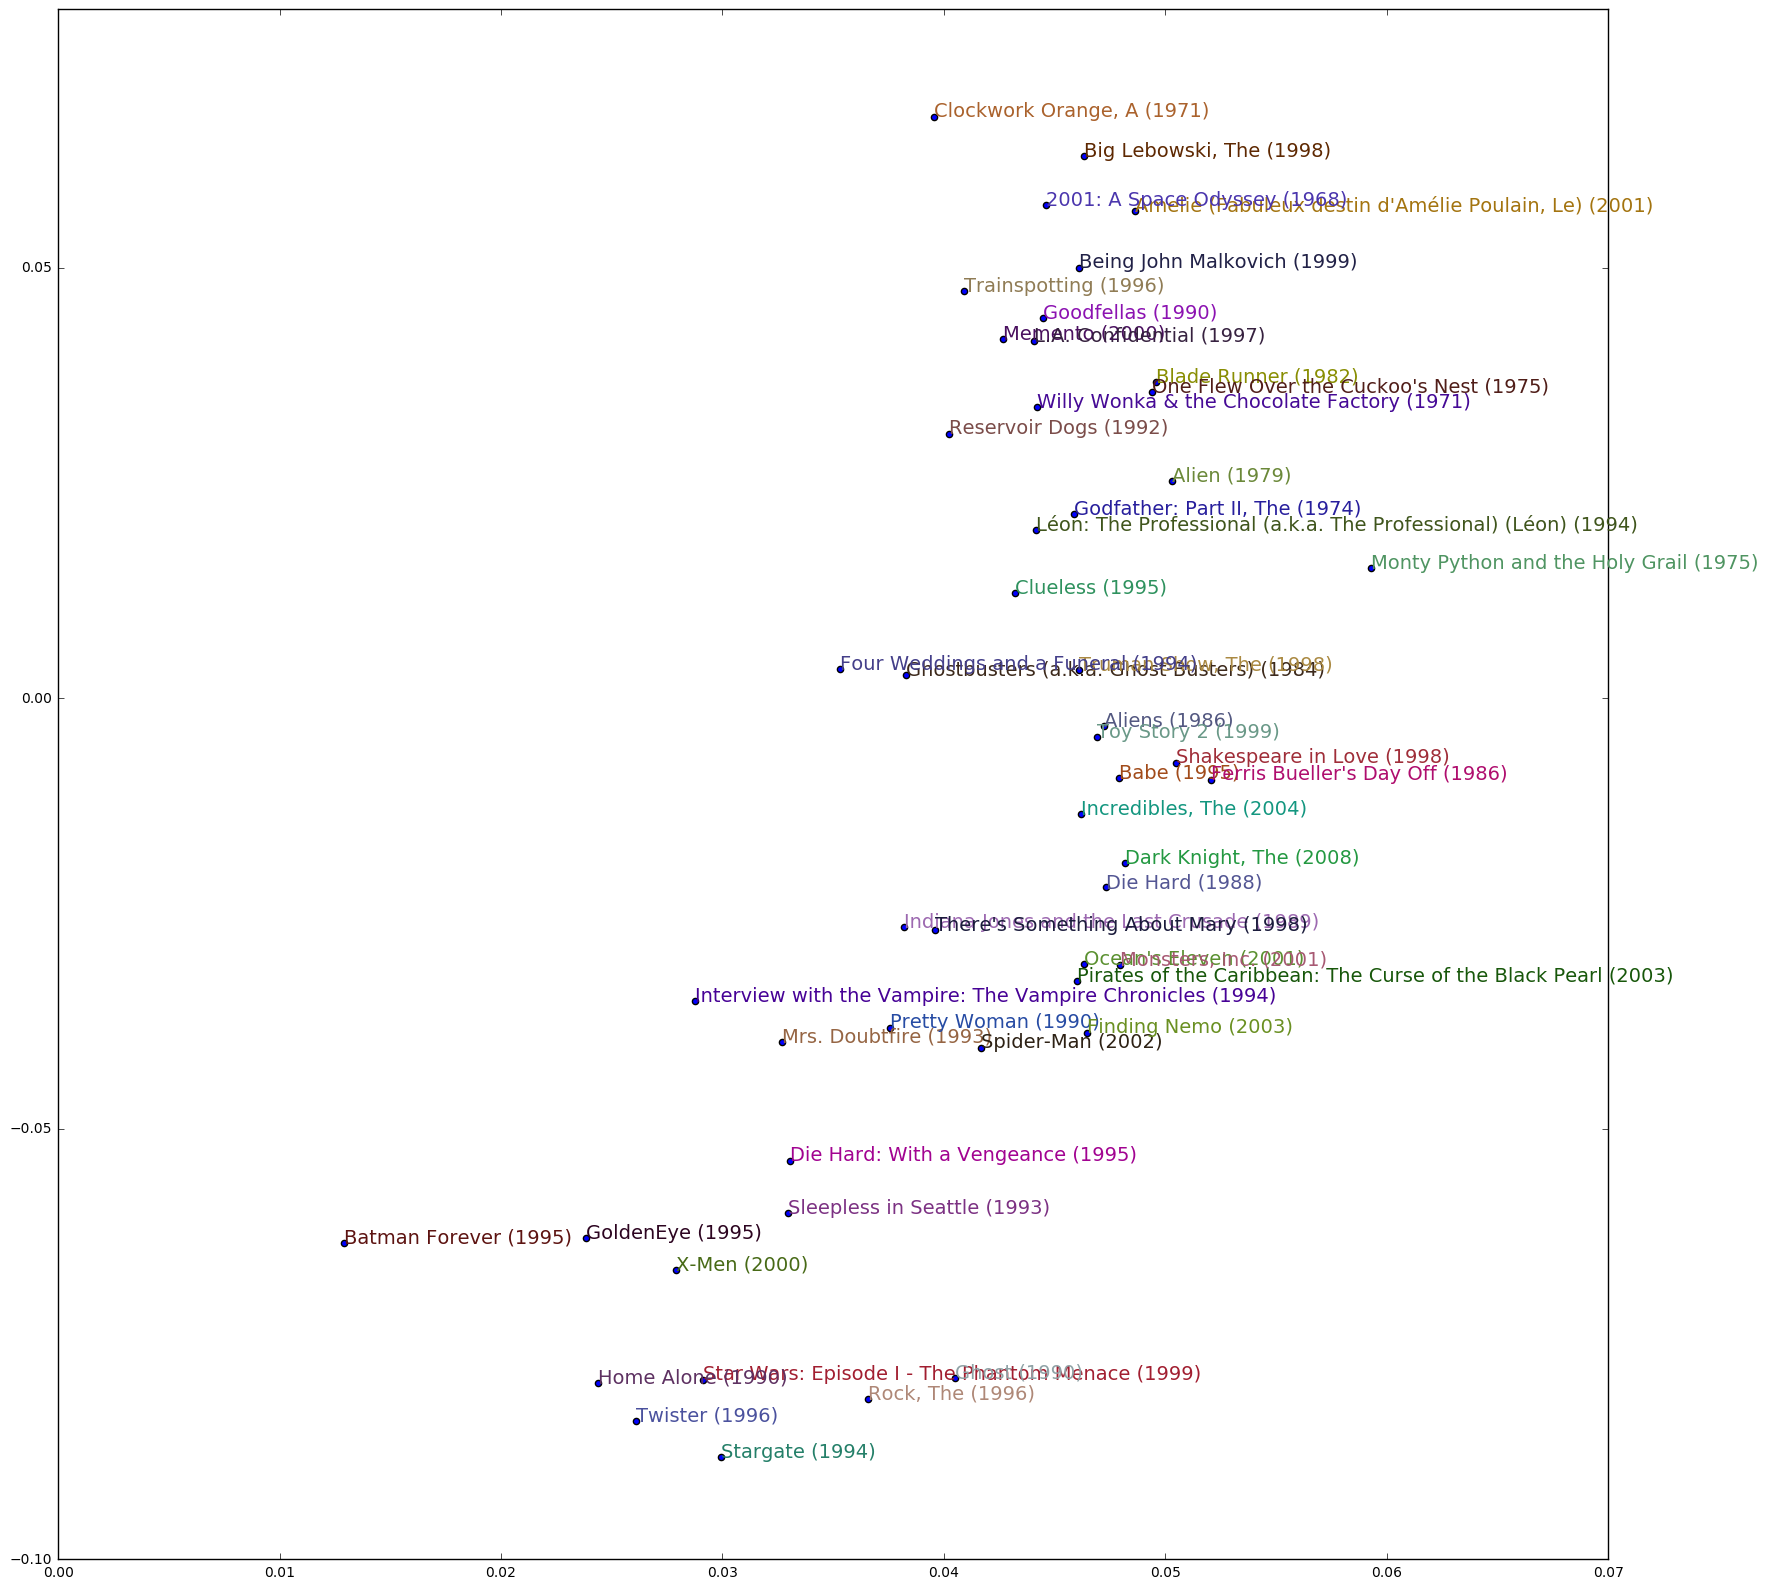

In [57]:
X = comp0[50:100]
Y = comp1[50:100]
plt.figure(figsize = (20,20))
plt.scatter(X,Y)
for i, x, y in zip(topMovies[50:100], X, Y):
    plt.text(x, y, movie_names[movies[i]], color = np.random.rand(3) * 0.7, fontsize = 14)
plt.show()

# Neural Net

Now that we've used the model architecture of the dot product with bias factors, let's try a neural network.

In [58]:
user_in, u = embedding_input('user_in', n_users, n_factors, 1e-4)
movie_in, m = embedding_input('movie_in', n_movies, n_factors, 1e-4)

In [61]:
x = merge([u, m], mode = 'concat')
x = Flatten()(x)
x = Dropout(.3)(x)
x = Dense(70, activation = 'relu')(x)
x = Dropout(.75)(x)
x = Dense(1)(x)
nn = Model([user_in, movie_in], x)
nn.compile(Adam(.001), loss = 'mse')

In [62]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size = 64, nb_epoch = 8, 
          validation_data = ([val.userId, val.movieId], val.rating))

Train on 80021 samples, validate on 19983 samples
Epoch 1/8
80021/80021 [==============================] - 34s - loss: 2.7445 - val_loss: 0.9127
Epoch 2/8
80021/80021 [==============================] - 29s - loss: 1.5120 - val_loss: 0.8335
Epoch 3/8
80021/80021 [==============================] - 23s - loss: 1.2702 - val_loss: 0.8114
Epoch 4/8
80021/80021 [==============================] - 21s - loss: 1.0920 - val_loss: 0.8051
Epoch 5/8
80021/80021 [==============================] - 20s - loss: 0.9630 - val_loss: 0.8005
Epoch 6/8
80021/80021 [==============================] - 20s - loss: 0.8918 - val_loss: 0.7893
Epoch 7/8
80021/80021 [==============================] - 20s - loss: 0.8455 - val_loss: 0.7862
Epoch 8/8
80021/80021 [==============================] - 21s - loss: 0.8294 - val_loss: 0.7880


In [63]:
model.optimizer.lr = .0001

In [64]:
nn.fit([trn.userId, trn.movieId], trn.rating, batch_size = 64, nb_epoch = 3, 
          validation_data = ([val.userId, val.movieId], val.rating))

Train on 80021 samples, validate on 19983 samples
Epoch 1/3
80021/80021 [==============================] - 21s - loss: 0.8177 - val_loss: 0.7848
Epoch 2/3
80021/80021 [==============================] - 22s - loss: 0.8124 - val_loss: 0.7869
Epoch 3/3
80021/80021 [==============================] - 23s - loss: 0.8072 - val_loss: 0.7877
